# Determinants of Women’s Principal Resource Provider Status

In [ ]:
! pip install numpy pandas sas7bdat matplotlib seaborn statsmodels scipy scikit-learn

In [28]:
import numpy as np                      # Importing NumPy for numerical operations
import pandas as pd                     # Importing Pandas for data manipulation
from sas7bdat import SAS7BDAT           # Importing SAS7BDAT to read SAS datasets

import matplotlib.pyplot as plt                         # Importing Matplotlib for plotting
import seaborn as sns                                   # Importing Seaborn for advanced visualizations
from statsmodels.graphics.gofplots import ProbPlot      # Importing ProbPlot for probability plots

import scipy.stats as stats                             # Importing SciPy statistics module
from scipy.stats import chi2                            # Importing chi-squared distribution for statistical tests
from scipy.stats import pearsonr, ttest_ind             # Importing Pearson correlation and t-test

import statsmodels.api as sm                            # Importing Statsmodels for statistical modeling
from statsmodels.stats.stattools import durbin_watson   # Importing Durbin-Watson test for autocorrelation

from sklearn.model_selection import cross_val_score                                  # Importing cross-validation for model evaluation
from sklearn.metrics import auc, precision_recall_curve, confusion_matrix, r2_score  # Importing various metrics for model evaluation
from sklearn.metrics import roc_curve, auc                                           # Importing ROC curve and AUC for classification performance
from sklearn.calibration import calibration_curve                                    # Importing calibration curve for probability calibration

## DataFrame

In [29]:
file_path = './data/individus_ct2013.sas7bdat'
with SAS7BDAT(file_path) as reader:
    df = reader.to_data_frame()
df.info()

[individus_ct2013.sas7bdat] column count mismatch
[individus_ct2013.sas7bdat] [individus_ct2013.sas7bdat] column count mismatch


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33673 entries, 0 to 33672
Columns: 541 entries, C1C to revmenscc_drap
dtypes: float64(76), object(465)
memory usage: 139.0+ MB


## Scope of the study
* We are only interested in individuals living in a couple in the same household.

In [30]:
df = df.query('COUPLE == "1"')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24024 entries, 2 to 33672
Columns: 541 entries, C1C to revmenscc_drap
dtypes: float64(76), object(465)
memory usage: 99.3+ MB


## Binary dependent variable

In [31]:
df['FPA'] = df.apply(lambda row: 1 if (row['PRACT'] == '1' and row['SEXE'] == '2') else 0, axis=1)      # Create the new column 'female_primary_contributor' with values 1 or 0
nb_FPA = df['FPA'].sum()        # Count the number of rows where 'female_primary_contributor' equals 1
print("Number of rows where 'female_primary_contributor' equals", nb_FPA)

Number of rows where 'female_primary_contributor' equals 5080


## Variable Selection

In [32]:
variables_dict = {
    'etat_civil_familial': ['ANAIS', 'ETAMATRI', 'PACS', 'MER1E', 'PER1E'],
    'situation_travail': ['SITUA', 'CJSITUA', 'RABS', 'STATUTEXT', 'METIER',],
    'revenus_conditions_vie': ['REVMENUC', 'AIDFAM'], 
    'caracteristiques_logement_familial': ['TYPOLOG', 'TYPMEN15', 'NPERS', 'NACTIFS'],
    'ajout': ['LIENPREF', 'LIEN_01', 'AGEQ', 'TRANCHRE']
}

# Access individual lists
print("* Marital and family status:", variables_dict['etat_civil_familial'])
print("* Employment situation:", variables_dict['situation_travail'])
print("* Income and living conditions:", variables_dict['revenus_conditions_vie'])
print("* Housing and family characteristics:", variables_dict['caracteristiques_logement_familial'])

* Marital and family status: ['ANAIS', 'ETAMATRI', 'PACS', 'MER1E', 'PER1E']
* Employment situation: ['SITUA', 'CJSITUA', 'RABS', 'STATUTEXT', 'METIER']
* Income and living conditions: ['REVMENUC', 'AIDFAM']
* Housing and family characteristics: ['TYPOLOG', 'TYPMEN15', 'NPERS', 'NACTIFS']


### Identification of variable types

In [33]:
explicatives = [var for sublist in variables_dict.values() for var in sublist]

numericals = [var for var in explicatives if pd.api.types.is_numeric_dtype(df[var]) or pd.api.types.is_datetime64_any_dtype(df[var])]
categoricals = [var for var in explicatives if isinstance(df[var].dtype, pd.CategoricalDtype) or df[var].dtype == 'object']
target = ['FPA']

print(f"Numerical variables: {numericals}")
print(f"Categorical variables: {categoricals}")

columns_to_keep = numericals + categoricals + target
df = df[columns_to_keep]

Numerical variables: ['ANAIS', 'REVMENUC', 'NPERS', 'NACTIFS']
Categorical variables: ['ETAMATRI', 'PACS', 'MER1E', 'PER1E', 'SITUA', 'CJSITUA', 'RABS', 'STATUTEXT', 'METIER', 'AIDFAM', 'TYPOLOG', 'TYPMEN15', 'LIENPREF', 'LIEN_01', 'AGEQ', 'TRANCHRE']


### Cleaning

In [34]:
df.replace('', 0, inplace=True)
df.replace(' ', 0, inplace=True)
df.fillna(0, inplace=True)

nan_count = df.isna().sum()
zero_count = (df == 0).sum()

print("Number of NaN per column:")
print(nan_count)

print("\nNumber of 0 per column:")
print(zero_count)

df.head(20)

Number of NaN per column:
ANAIS        0
REVMENUC     0
NPERS        0
NACTIFS      0
ETAMATRI     0
PACS         0
MER1E        0
PER1E        0
SITUA        0
CJSITUA      0
RABS         0
STATUTEXT    0
METIER       0
AIDFAM       0
TYPOLOG      0
TYPMEN15     0
LIENPREF     0
LIEN_01      0
AGEQ         0
TRANCHRE     0
FPA          0
dtype: int64

Number of 0 per column:
ANAIS            0
REVMENUC      1035
NPERS          112
NACTIFS         78
ETAMATRI         0
PACS         17004
MER1E           18
PER1E           38
SITUA            4
CJSITUA          4
RABS         21471
STATUTEXT    19078
METIER           0
AIDFAM       23932
TYPOLOG          0
TYPMEN15         0
LIENPREF         4
LIEN_01          0
AGEQ             0
TRANCHRE     17755
FPA          18944
dtype: int64


,ANAIS,REVMENUC,NPERS,NACTIFS,ETAMATRI,PACS,MER1E,PER1E,SITUA,CJSITUA,...,STATUTEXT,METIER,AIDFAM,TYPOLOG,TYPMEN15,LIENPREF,LIEN_01,AGEQ,TRANCHRE,FPA
2,1963.0,766.666667,5.0,2.0,2,0,3,2,4,1,...,0,2,1,1,42,01,01,45,0,0
3,1969.0,0.000000,2.0,1.0,2,0,2,3,1,6,...,0,2,0,1,31,00,00,40,1,0
5,1971.0,785.714286,4.0,2.0,2,0,2,3,1,4,...,0,1,0,1,42,00,01,40,7,0
6,1948.0,1466.666667,2.0,2.0,2,0,3,3,1,1,...,0,2,0,1,32,01,00,60,0,0
7,1961.0,292.608696,4.0,1.0,1,2,2,2,1,6,...,0,2,0,1,41,00,00,50,0,0
9,1976.0,625.000000,5.0,2.0,2,0,2,2,1,4,...,0,2,0,1,42,00,00,35,0,0
11,1959.0,450.000000,3.0,3.0,2,0,2,2,1,1,...,0,2,0,1,42,00,01,50,0,1
15,1966.0,1029.411765,7.0,1.0,2,0,2,2,1,6,...,0,1,0,1,41,00,00,45,0,0
18,1958.0,2666.666667,2.0,2.0,1,1,2,2,1,1,...,0,9,0,1,32,01,01,50,0,0
19,1963.0,1300.000000,3.0,2.0,2,0,2,1,1,1,...,0,2,0,1,52,00,00,45,0,0


## Distribution

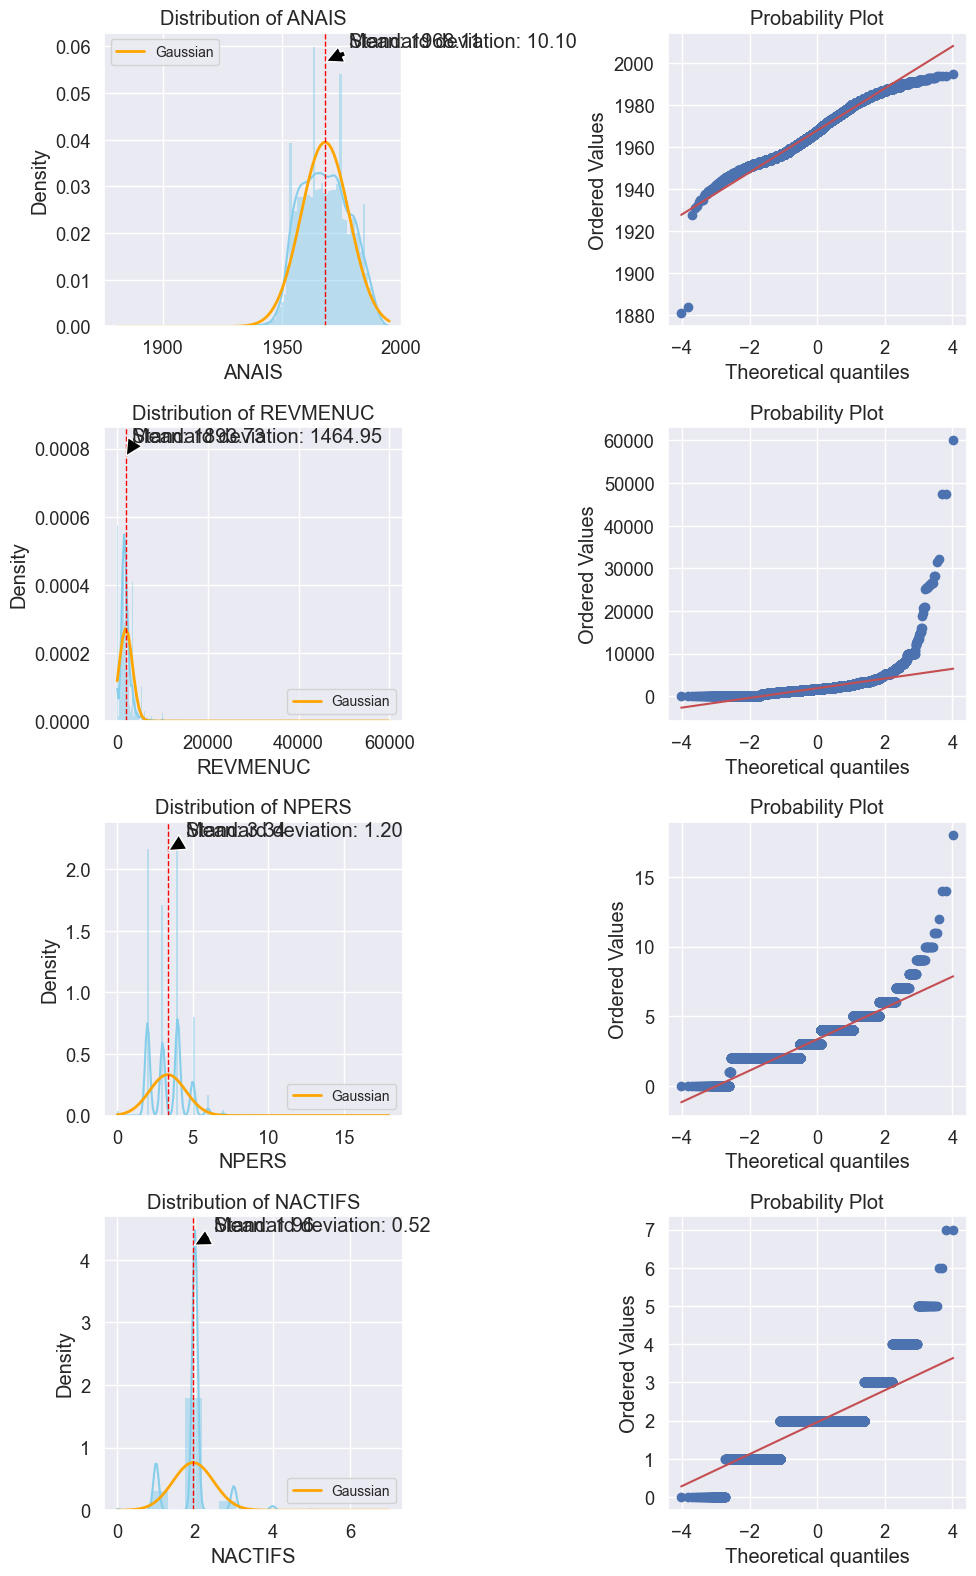

In [35]:
def plot_continuous_variables(df, numericals):
    
    num_vars = len(numericals)      # Create a grid of subplots with 2 columns
    fig, axes = plt.subplots(num_vars, 2, figsize=(10, 4*num_vars))
    
    for i, var in enumerate(numericals):
        
        ax = axes[i, 0]     # Distribution of the variable (Gaussian curve)
        ax.set_title(f'Distribution of {var}')
        ax.grid(True)
        
        sns.histplot(df[var], kde=True, ax=ax, color='skyblue', stat='density', linewidth=0)            # Use seaborn for distribution plot 

        xmin, xmax = df[var].min(), df[var].max()        # Plot the corresponding Gaussian curve
        mean, std_dev = df[var].mean(), df[var].std()
        x = np.linspace(xmin, xmax, 100)
        ax.plot(x, stats.norm.pdf(x, mean, std_dev), label='Gaussian', color='orange', linewidth=2)
        ax.legend(prop={'size': 10})
        
        ax.axvline(mean, color='red', linestyle='dashed', linewidth=1)      # Add annotations for the mean and standard deviation
        ax.annotate(f'Mean: {mean:.2f}', xy=(mean, ax.get_ylim()[1]*0.9), xytext=(mean + std_dev, ax.get_ylim()[1]*0.95),
                    arrowprops=dict(facecolor='black', shrink=0.05))
        ax.annotate(f'Standard deviation: {std_dev:.2f}', xy=(mean + std_dev, ax.get_ylim()[1]*0.95))
        
        ax = axes[i, 1]                         # Q-Q plot of the variable
        ax.set_title(f'Q-Q plot of {var}')
        ax.grid(True)
        
        stats.probplot(df[var], dist="norm", plot=ax)       # Use scipy.stats to calculate the Q-Q plot
        
    plt.tight_layout()
    plt.show()

plot_continuous_variables(df, numericals)

## Analysis of dependencies
### (1) Numerical____
####    Correlation analysis

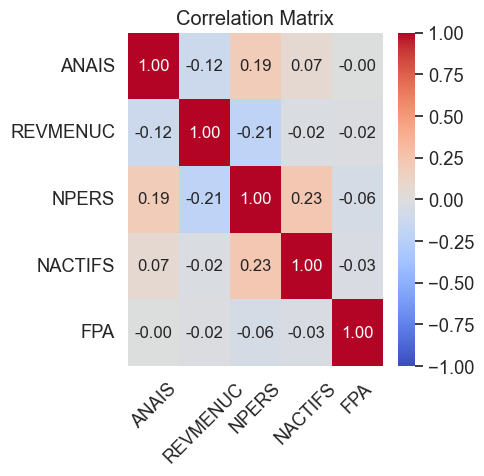

In [36]:
def plot_correlation_matrix(df, numericals, target):

    corr_matrix = df[numericals + target].corr()
    plt.figure(figsize=(5, 5))
    sns.set(font_scale=1.2)
    
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 12}, vmin=-1, vmax=1)
    
    plt.title('Correlation Matrix')
    plt.yticks(rotation=0)
    plt.xticks(rotation=45)
    plt.tight_layout()

    plt.show()

plot_correlation_matrix(df, numericals, target)

####    Student's T-test
- `Null hypothesis (H0)`: There is no significant difference between the means of continuous variables for the groups defined by the 'FPA' variable.
- `Alternative hypothesis (H1)`: There is a significant difference between the means of continuous variables for the groups defined by the 'FPA' variable.

In [37]:
def test_association_with_fpa(df, numericals, target, alpha=0.05):
    print("___Student's t-test___\n")   

    new_columns = numericals + target
    groups = df[new_columns].groupby(target)
    group0 = groups.get_group((0,))
    group1 = groups.get_group((1,))


    results = []

    for var in numericals:
        t_stat, p_value = stats.ttest_ind(group0[var], group1[var], equal_var=False)
        
        if np.isnan(p_value):           # Interpret the results
            significant = "NaN"
        elif p_value < alpha:
            significant = "yes"
        else:
            significant = "no"
        
        results.append({                # Add the results to the results list
        'Variable': var,
        't-statistic': t_stat,
        'p-value': p_value,
        'Significant': significant, 
        'Impact': abs(t_stat)
        })
    
    results_sorted = sorted(results, key=lambda x: x['Impact'], reverse=True)
    df_results = pd.DataFrame(results_sorted)
    df_styled = df_results.style.apply(lambda row: ['background-color: lightgreen' if x == 'yes' else '' for x in row], axis=1)

    impactful_variables = df_results[df_results['Significant'] == 'yes']['Variable'].tolist()
    print(f"Significant variables: {impactful_variables}")

    return df_styled
        
test_association_with_fpa(df, numericals, target, alpha=0.05)

___Student's t-test___

Significant variables: ['NPERS', 'NACTIFS', 'REVMENUC']


,Variable,t-statistic,p-value,Significant,Impact
0,NPERS,9.867643,0.000000,yes,9.867643
1,NACTIFS,5.250738,0.000000,yes,5.250738
2,REVMENUC,3.318431,0.000909,yes,3.318431
3,ANAIS,0.480623,0.630798,no,0.480623


#### Selection of numercials_

In [38]:
numericals = ['NPERS', 'NACTIFS', 'REVMENUC']
new_columns = numericals + categoricals + target 
df = df[new_columns].copy()

### (2) Categoricals____
#### Contingency tables

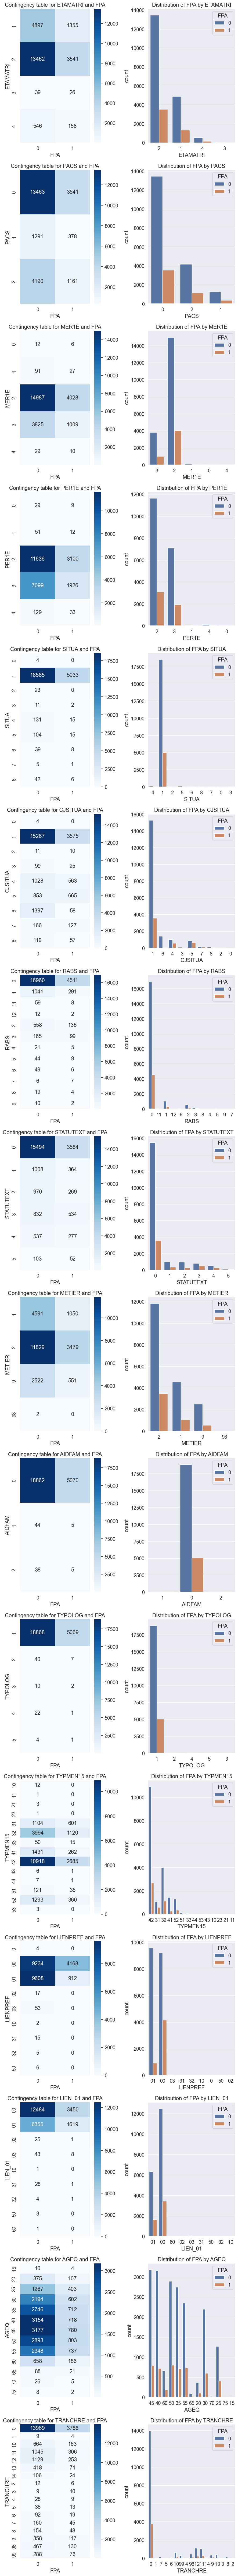

In [39]:
def create_contingency_tables(df, categoricals, target='FPA'):

    num_categoricals = len(categoricals)
    fig, axs = plt.subplots(num_categoricals, 2, figsize=(9, num_categoricals * 6))
    
    for i, var in enumerate(categoricals):
        
        contingency_table = pd.crosstab(df[var], df[target])    # Create a contingency table between the categorical variable and 'FPA'
        
        axs[i, 0].set_title(f'Contingency table for {var} and {target}')                    # Display the contingency table
        sns.heatmap(contingency_table, annot=True, fmt='d', cmap='Blues', ax=axs[i, 0])
        
        sns.countplot(x=var, hue=target, data=df, ax=axs[i, 1])         # plot showing the distribution of 'FPA' by category of the categorical variable
        axs[i, 1].set_title(f'Distribution of {target} by {var}')
        axs[i, 1].legend(title=target)
        
        plt.tight_layout()
    plt.show()

create_contingency_tables(df, categoricals, target='FPA')

#### Chi-squared test to assess their association with the dependent variable.

- `Null hypothesis (H0)`: There is no relationship between the categorical variable and the target variable 'FAP'.
- `Alternative hypothesis (H1)`: There is a relationship between the categorical variable and the target variable 'FAP'.

In [40]:
def khi2_test_association(df, categoricals, target='FPA', alpha=0.05):
    print("___Chi-Square Test___\n")   
    results = []
    
    for var in categoricals:
        
        contingency_table = pd.crosstab(df[var], df[target])    # Create a contingency table between the categorical variable and 'FPA'
        chi2, p_value, _, _ = stats.chi2_contingency(contingency_table)     # Perform the chi-square test
        
        if p_value < alpha:     # Interpret the results
            impact = 'Yes'
        else:
            impact = 'No'
        
        results.append({        # Add the results to the list
            'variable': var,
            'statistic': chi2,
            'p-value': p_value,
            'impact': impact
        })
            
    results_sorted = sorted(results, key=lambda x: x['statistic'], reverse=True)
    df_results = pd.DataFrame(results_sorted)  

    impactful_variables = df_results[df_results['impact'] == 'Yes']['variable'].tolist()    # Filter variables with significant impact ('Yes')
    print("Categoricals with statistical significant impact:", impactful_variables)   
    
    # Apply conditional styling to highlight rows with impact == 'Yes'
    df_styled = df_results.style.apply(lambda row: ['background-color: lightgreen' if x == 'Yes' else '' for x in row], axis=1)
    
    return df_styled

khi2_test_association(df, categoricals, target='FPA', alpha=0.05)

___Chi-Square Test___

Categoricals with statistical significant impact: ['LIENPREF', 'CJSITUA', 'STATUTEXT', 'TYPMEN15', 'METIER', 'RABS', 'AGEQ', 'TRANCHRE', 'SITUA', 'LIEN_01', 'ETAMATRI']


,variable,statistic,p-value,impact
0,LIENPREF,1805.855593,0.000000,Yes
1,CJSITUA,1081.203884,0.000000,Yes
2,STATUTEXT,446.994010,0.000000,Yes
3,TYPMEN15,260.563617,0.000000,Yes
4,METIER,64.225270,0.000000,Yes
5,RABS,60.517425,0.000000,Yes
6,AGEQ,46.995852,0.000005,Yes
7,TRANCHRE,43.617937,0.000225,Yes
8,SITUA,26.140004,0.000994,Yes
9,LIEN_01,18.210116,0.019705,Yes


#### ANOVA (Analysis of Variance) test
- `H0 (null hypothesis)`: The means of the groups defined by the categorical variable are equal.
- `H1 (alternative hypothesis)`: At least one pair of group means is different.

In [41]:
def anova_test(df, categoricals, target='FPA', alpha=0.05):
    print("___ANOVA Test___\n")  
    results = []
    
    for var in categoricals:
        
        groups = []                                 # Collect data for ANOVA
        for category in df[var].unique():
            group_data = df[df[var] == category][target]
            groups.append(group_data)
        
        f_statistic, p_value = stats.f_oneway(*groups)      # Perform ANOVA
        
        if p_value < alpha:     # Interpret the results
            result = 'Yes'
        else:
            result = 'No'
        
        results.append({                     # Add the results to the list
            'variable': var,
            'F-statistic': f_statistic,
            'p-value': p_value,
            'result': result
        })

    results_sorted = sorted(results, key=lambda x: x['F-statistic'], reverse=True)   
    df_results = pd.DataFrame(results_sorted)
    
    def highlight_yes(s):       # Apply conditional styling to highlight rows with result == 'Yes'
        return ['background-color: lightgreen' if v == 'Yes' else '' for v in s]
    
    styled_df = df_results.style.apply(highlight_yes, subset=['result'])

    significant_vars = df_results[df_results['p-value'] < alpha]['variable'].tolist()
    if significant_vars:
        print(f"Categoricals with statistical significant impact on {target} (p-value < 0.05): {', '.join(significant_vars)}")
    else:
        print(f"None of the tested variables have a statistically significant effect on {target} (p-value < 0.05).")

    return styled_df

styled_results = anova_test(df, categoricals, target='FPA', alpha=0.05)
styled_results

___ANOVA Test___

Categoricals with statistical significant impact on FPA (p-value < 0.05): LIENPREF, CJSITUA, STATUTEXT, METIER, TYPMEN15, ETAMATRI, RABS, AGEQ, SITUA, TRANCHRE, LIEN_01


,variable,F-statistic,p-value,result
0,LIENPREF,243.987646,0.000000,Yes
1,CJSITUA,141.466580,0.000000,Yes
2,STATUTEXT,91.070954,0.000000,Yes
3,METIER,21.462235,0.000000,Yes
4,TYPMEN15,20.251320,0.000000,Yes
5,ETAMATRI,5.554646,0.000831,Yes
6,RABS,5.512723,0.000000,Yes
7,AGEQ,3.921874,0.000005,Yes
8,SITUA,3.269834,0.000991,Yes
9,AIDFAM,2.938587,0.052959,No


#### Selection of categorcials_

In [42]:
categoricals = ['LIENPREF', 'CJSITUA', 'STATUTEXT', 'TYPMEN15', 'METIER', 'RABS', 'AGEQ', 'TRANCHRE', 'SITUA', 'LIEN_01', 'ETAMATRI']
new_columns = numericals + categoricals + target
df = df[new_columns].copy()

### (3) Multicollinearity
- VIF < 15 `(OK)`
- VIF > 15 `(NOK)`

In [43]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')       # Convert to numeric, replace errors with NaN

X = sm.add_constant(df)                 # Add constant to estimate the intercept
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print("Variance Inflation Factors (VIF):")
print(vif_data)

Variance Inflation Factors (VIF):
      Feature         VIF
0       const  107.025870
1       NPERS    1.680660
2     NACTIFS    1.696804
3    REVMENUC    1.161412
4    LIENPREF    1.233200
5     CJSITUA    1.632921
6   STATUTEXT    1.051653
7    TYPMEN15    1.658593
8      METIER    1.007138
9        RABS    1.015478
10       AGEQ    1.326123
11   TRANCHRE    1.085493
12      SITUA    1.073910
13    LIEN_01    1.215993
14   ETAMATRI    1.162278
15        FPA    1.046888


### (5) Model construction
* Initial construction

In [44]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

df[categoricals] = df[categoricals].astype(str)

# Split features and target
X = df[numericals + categoricals]   # Explanatory variables
y = df['FPA']                       # Target variable

# Prepare transformations for the data
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Impute missing values with the mean
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Impute missing values with the most frequent value
    ('onehot', OneHotEncoder(drop='first'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numericals),
        ('cat', categorical_transformer, categoricals)
    ])

model = Pipeline(steps=[                # Create a pipeline with the preprocessor and model
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(class_weight='balanced', max_iter=1000))
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)       # Split the data into training and testing sets

model.fit(X_train, y_train)             # Train the model
y_pred = model.predict(X_test)          # Make predictions and evaluate the model

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.63      0.74      3756
           1       0.36      0.74      0.49      1049

    accuracy                           0.66      4805
   macro avg       0.63      0.69      0.61      4805
weighted avg       0.78      0.66      0.69      4805

[[2377 1379]
 [ 269  780]]


### (6) Model diagnostics
* Check for linearity in the logit

/Users/mariusayrault/GitHub/Sorb-Data-Analytics/projet-statistique/.venv/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


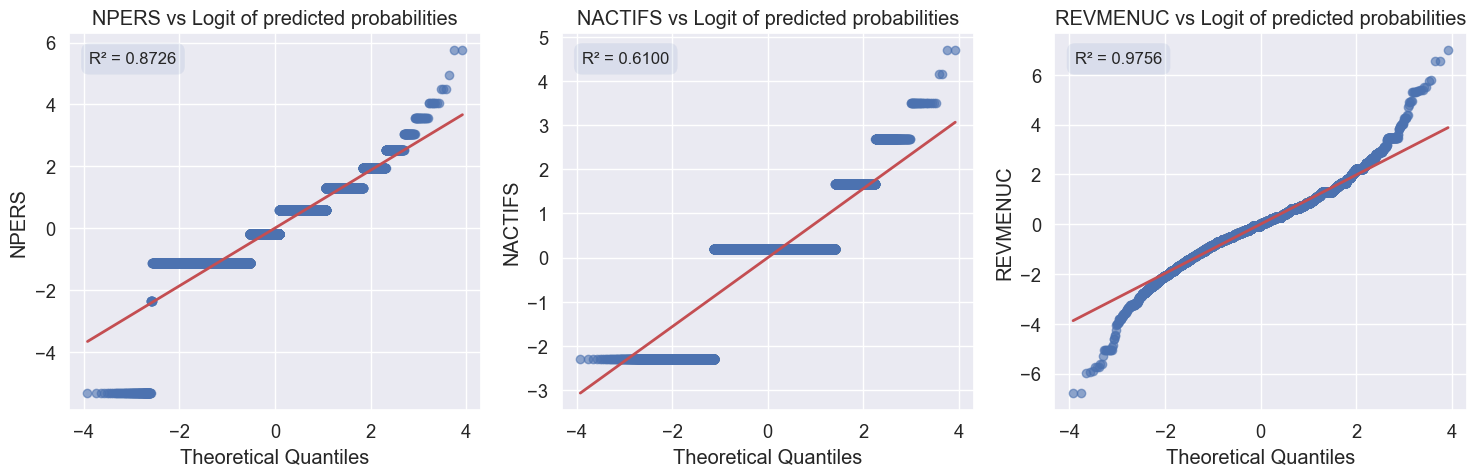

In [45]:
from scipy.stats import boxcox

def transform_data(df): 
    df['REVMENUC'] = np.log(df['REVMENUC'])
    df['NACTIFS'] = np.log(df['NACTIFS'])
    
    df = df.replace([np.inf, -np.inf], np.nan).dropna()     # Clean the data
   
    df['NPERS'] = np.sqrt(df['NPERS'])
    
    final_df = df.copy()
    return final_df 

final_df = transform_data(df)

def check_linearity_in_logit(final_df, numericals, target='FPA'):
     
    df = sm.add_constant(final_df)      # Add a constant to the DataFrame
    
    logit_model = sm.Logit(df[target], df[numericals])      # Fit the logistic regression model
    logit_results = logit_model.fit(disp=0)
    
    predicted_logit = logit_results.predict()   # Calculate the predicted probabilities in logit
    
    fig, axes = plt.subplots(nrows=1, ncols=len(numericals), figsize=(15, 5))
    
    for i, var in enumerate(numericals):
        
        probplot = ProbPlot(df[var], fit=True)          # Scatter plot (continuous variable vs logit of predicted probabilities)
        axes[i].scatter(probplot.theoretical_quantiles, probplot.sample_quantiles, alpha=0.6)
        axes[i].set_title(f"{var} vs Logit of predicted probabilities")
        axes[i].set_xlabel(f"Theoretical Quantiles")
        axes[i].set_ylabel(f"{var}")
        axes[i].grid(True)
        
        fit = np.polyfit(probplot.theoretical_quantiles, probplot.sample_quantiles, 1)      # Add the regression line
        fit_values = np.polyval(fit, probplot.theoretical_quantiles)
        axes[i].plot(probplot.theoretical_quantiles, fit_values, 'r-', linewidth=2)
        
        r2 = r2_score(probplot.sample_quantiles, fit_values)     # Calculate R² for linearity
        
        axes[i].text(0.05, 0.95, f'R² = {r2:.4f}', transform=axes[i].transAxes,                                 # Display R² on the plot
                     fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', alpha=0.1))
    
    plt.tight_layout()
    plt.show()

check_linearity_in_logit(final_df, numericals, target='FPA')

### (7) Model validation

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24024 entries, 2 to 33672
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   NPERS      24024 non-null  float64
 1   NACTIFS    24024 non-null  float64
 2   REVMENUC   24024 non-null  float64
 3   LIENPREF   24024 non-null  object 
 4   CJSITUA    24024 non-null  object 
 5   STATUTEXT  24024 non-null  object 
 6   TYPMEN15   24024 non-null  object 
 7   METIER     24024 non-null  object 
 8   RABS       24024 non-null  object 
 9   AGEQ       24024 non-null  object 
 10  TRANCHRE   24024 non-null  object 
 11  SITUA      24024 non-null  object 
 12  LIEN_01    24024 non-null  object 
 13  ETAMATRI   24024 non-null  object 
 14  FPA        24024 non-null  int64  
dtypes: float64(3), int64(1), object(11)
memory usage: 2.9+ MB


In [47]:
def final_model(final_df, numericals, categoricals, target='FPA', num_groups=10):
    
    df = sm.add_constant(final_df)
        
    exog_numericals = df[numericals].values               # Select explanatory variables for the logistic regression model
    exog_categoricals = pd.get_dummies(df[categoricals], drop_first=True).values
    
    scaler = StandardScaler()
    exog_numericals_scaled = scaler.fit_transform(exog_numericals)
    
    exog = np.concatenate((exog_numericals_scaled, exog_categoricals), axis=1)  # Combine the explanatory variables
        
    model = sm.Logit(df[target], exog)      # Fit the logistic regression model
    results = model.fit_regularized(maxiter=1000, alpha=0.00000001)
    
    residuals = results.resid_pearson
       
    # DURBIN-WATSON TEST
    durbin_watson_statistic = durbin_watson(residuals)
    print(f"\n-----------------------------------------------------------------------------\nDurbin-Watson statistic: {durbin_watson_statistic:.4f}")
        
    if durbin_watson_statistic < 1.5:
        print("The residuals show positive autocorrelation.\n")
    elif durbin_watson_statistic > 2.5:
        print("The residuals show negative autocorrelation.\n")
    else:
        print("The residuals do not show significant autocorrelation.\n")

    # HOSMER-LEMESHOW TEST
    y_true = df[target].values
    y_prob = results.predict(exog)

    if len(y_true) != len(y_prob):              # Check the dimensions of the data
        raise ValueError("The dimensions of y_true and y_prob must be identical.")
    
    y_true = np.asarray(y_true)     # Create groups based on predicted probabilities
    y_prob = np.asarray(y_prob)
    deciles = np.percentile(y_prob, np.arange(0, 100, 100/num_groups))
    groups = np.digitize(y_prob, deciles)
    
    obs_freq = np.zeros(num_groups)     # Initialize arrays for observed and expected frequencies
    exp_freq = np.zeros(num_groups)
    
    
    for i in range(num_groups):                                # Calculate observed and expected frequencies for each group
        obs_freq[i] = np.sum((groups == (i + 1)) * y_true)
        exp_freq[i] = np.sum(groups == (i + 1)) * np.mean(y_true)
    
    chi2_statistic = np.sum((obs_freq - exp_freq)**2 / exp_freq)        # Calculate the Hosmer-Lemeshow test statistic
    df_hl = num_groups - 2      # Degrees of freedom is (num_groups - 2) because there are num_groups - 1 groups and 2 parameters (intercept and slope)
    p_value_hl = 1 - chi2.cdf(chi2_statistic, df_hl)    # Calculate p-value

    print(f"\n-----------------------------------------------------------------------------\nHosmer-Lemeshow test statistic: {chi2_statistic:.4f}")
    print(f"P-value: {p_value_hl:.4f}")

    # Interpret the results of the Hosmer-Lemeshow test
    if p_value_hl < 0.05:
        print("The model does not fit the observed data well (reject the null hypothesis).\n")
    else:
        print("The model fits the observed data well (no evidence to reject the null hypothesis).\n")
    
    # MODEL VALIDATION
    X_train, X_test, y_train, y_test = train_test_split(exog, df[target], test_size=0.2, random_state=42)   # Split the data into training and test sets
   
    logreg = LogisticRegression()        # Perform cross-validation with LogisticRegression from scikit-learn    
    logreg.fit(X_train, y_train)        # Fit the model on training data
    
    accuracy_scores = cross_val_score(logreg, X_train, y_train, cv=5, scoring='accuracy')       # Perform cross-validation
    precision_scores = cross_val_score(logreg, X_train, y_train, cv=5, scoring='precision')
    recall_scores = cross_val_score(logreg, X_train, y_train, cv=5, scoring='recall')
    roc_auc_scores = cross_val_score(logreg, X_train, y_train, cv=5, scoring='roc_auc')
    
    mean_accuracy = accuracy_scores.mean()      # Calculate mean scores
    mean_precision = precision_scores.mean()
    mean_recall = recall_scores.mean()
    mean_roc_auc = roc_auc_scores.mean()

    print("\n----------------------------------")
    print("Model validation with cross-validation:")
    print(f"Accuracy: {mean_accuracy:.4f}")
    print(f"Precision: {mean_precision:.4f}")
    print(f"Recall: {mean_recall:.4f}")
    print(f"AUC-ROC: {mean_roc_auc:.4f}")
    
    results = {                         
        'Accuracy': mean_accuracy,
        'Precision': mean_precision,
        'Recall': mean_recall,
        'AUC-ROC': mean_roc_auc
    }

    return y_true, y_prob

y_true, y_prob = final_model(final_df, numericals, categoricals, target='FPA', num_groups=10)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.4303280421041951
            Iterations: 600
            Function evaluations: 601
            Gradient evaluations: 600

-----------------------------------------------------------------------------
Durbin-Watson statistic: 1.8409
The residuals do not show significant autocorrelation.


-----------------------------------------------------------------------------
Hosmer-Lemeshow test statistic: 3397.2412
P-value: 0.0000
The model does not fit the observed data well (reject the null hypothesis).



/Users/mariusayrault/GitHub/Sorb-Data-Analytics/projet-statistique/.venv/lib/python3.10/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 87 out of 88 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
/Users/mariusayrault/GitHub/Sorb-Data-Analytics/projet-statistique/.venv/lib/python3.10/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)



----------------------------------
Model validation with cross-validation:
Accuracy: 0.8163
Precision: 0.7036
Recall: 0.2476
AUC-ROC: 0.7692



Hypotheses:
- H0: The woman is not the primary resource provider in the household.
- H1: The woman is the primary resource provider in the household.

76.68% (True Negatives) 		 2.18% (False Positives)
15.90% (False Negatives) 		 5.24% (True Positives)

Interpretation of H0:
- True Negatives 76.68 % (Women correctly identified as not the primary resource provider according to H0)
- False Positives 2.18 % (Women incorrectly identified as the primary resource provider according to H0)

Interpretation of H1:
- True Positives 5.24 % (Women correctly identified as the primary resource provider according to H1)
- False Negatives 15.90 % (Women incorrectly identified as not the primary resource provider according to H1)


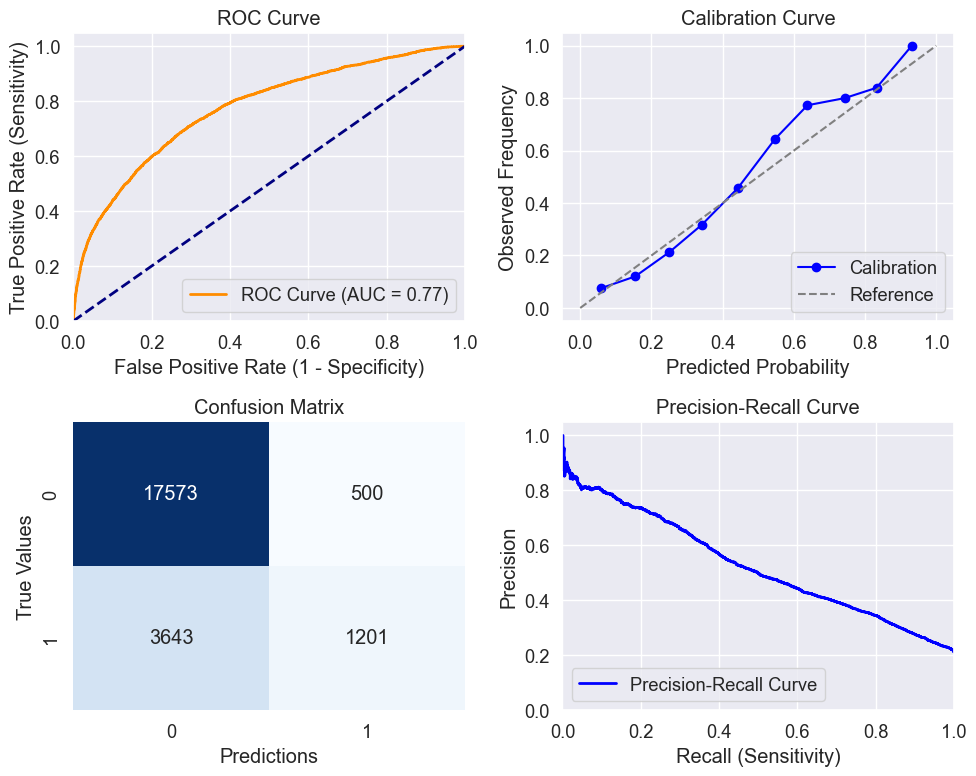

In [48]:
from sklearn.metrics import roc_curve, auc, confusion_matrix, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.calibration import calibration_curve

def plot_roc_curve(ax, y_true, y_prob):
    """
    Plot the ROC curve on the given axis.

    :param ax: Matplotlib axis to plot the ROC curve.
    :param y_true: Array-like, true labels (0 or 1).
    :param y_prob: Array-like, predicted probabilities for the positive class.
    
    :return: None
    """
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate (1 - Specificity)')
    ax.set_ylabel('True Positive Rate (Sensitivity)')
    ax.set_title('ROC Curve')
    ax.legend(loc="lower right")


def plot_calibration_curve(ax, y_true, y_prob):
    """
    Plot the calibration curve on the given axis.

    :param ax: Matplotlib axis to plot the calibration curve.
    :param y_true: Array-like, true labels (0 or 1).
    :param y_prob: Array-like, predicted probabilities for the positive class.
    
    :return: None
    """
    prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=10)
    ax.plot(prob_pred, prob_true, marker='o', color='blue', label='Calibration')
    ax.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Reference')
    ax.set_xlabel('Predicted Probability')
    ax.set_ylabel('Observed Frequency')
    ax.set_title('Calibration Curve')
    ax.legend(loc="lower right")


def plot_confusion_matrix(ax, y_true, y_prob):
    """
    Plot the confusion matrix on the given axis.

    :param ax: Matplotlib axis to plot the confusion matrix.
    :param y_true: Array-like, true labels (0 or 1).
    :param y_prob: Array-like, predicted probabilities for the positive class.
    
    :return: None
    """
    y_pred = (y_prob > 0.5).astype(int)
    cm = confusion_matrix(y_true, y_pred)

    cm_percent = cm / cm.sum() * 100

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax)
    ax.set_xlabel('Predictions')
    ax.set_ylabel('True Values')
    ax.set_title('Confusion Matrix')

    # Interpretation specific to the objective
    # Hypotheses
    print("\nHypotheses:")
    print("- H0: The woman is not the primary resource provider in the household.")
    print("- H1: The woman is the primary resource provider in the household.\n")

    print(f"{cm_percent[(0, 0)]:.2f}% (True Negatives) \t\t {cm_percent[(0, 1)]:.2f}% (False Positives)")
    print(f"{cm_percent[(1, 0)]:.2f}% (False Negatives) \t\t {cm_percent[(1, 1)]:.2f}% (True Positives)")

    # Explanation for H0
    print("\nInterpretation of H0:")
    print(f"- True Negatives {cm_percent[(0, 0)]:.2f} % (Women correctly identified as not the primary resource provider according to H0)")
    print(f"- False Positives {cm_percent[(0, 1)]:.2f} % (Women incorrectly identified as the primary resource provider according to H0)")

    # Explanation for H1
    print("\nInterpretation of H1:")
    print(f"- True Positives {cm_percent[(1, 1)]:.2f} % (Women correctly identified as the primary resource provider according to H1)")
    print(f"- False Negatives {cm_percent[(1, 0)]:.2f} % (Women incorrectly identified as not the primary resource provider according to H1)")


def plot_precision_recall_curve(ax, y_true, y_prob):
    """
    Plot the Precision-Recall curve on the given axis.

    :param ax: Matplotlib axis to plot the Precision-Recall curve.
    :param y_true: Array-like, true labels (0 or 1).
    :param y_prob: Array-like, predicted probabilities for the positive class.
    
    :return: None
    """
    precision, recall, thresholds = precision_recall_curve(y_true, y_prob)
    ax.plot(recall, precision, color='blue', lw=2, label='Precision-Recall Curve')
    ax.set_xlabel('Recall (Sensitivity)')
    ax.set_ylabel('Precision')
    ax.set_title('Precision-Recall Curve')
    ax.legend(loc="lower left")
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))  # Create the figure and subplots

plot_roc_curve(axs[0, 0], y_true, y_prob)                   # First subplot: plot_roc_curve
plot_calibration_curve(axs[0, 1], y_true, y_prob)           # Second subplot: plot_calibration_curve
plot_confusion_matrix(axs[1, 0], y_true, y_prob)            # Third subplot: plot_confusion_matrix
plot_precision_recall_curve(axs[1, 1], y_true, y_prob)      # Fourth subplot: plot_precision_recall_curve

plt.tight_layout()
plt.show()